In [1]:
import pandas as pd
import numpy as np
import faiss
import time
import matplotlib.pyplot as plt
import warnings
import gc

from tqdm.notebook import tqdm

warnings.simplefilter("ignore", UserWarning)

PATH = '***'

# Load data

## Base

### Base dataset

In [2]:
df_base = pd.read_csv(PATH + 'base.csv', index_col=0)
df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


### Create index with FAISS

In [3]:
dims = df_base.shape[1]
n_cells = 1000 # how many cells
n_neigbours = 30 # num of candidates
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.nprobe = 200

**note that `n_neigbours` is set to 30 because lack of RAM on the local machine. Recommended value is >= 100*

In [4]:
idx_l2.train(np.ascontiguousarray(df_base).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [5]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

## Train & Validation

### EDA

All features in datasets are unnamed columns and numbers so we do not khow what each of them means.

In [6]:
df_train = pd.read_csv(PATH + 'train.csv', index_col=0)
df_valid = pd.read_csv(PATH + 'validation.csv', index_col=0)

In [7]:
targets_train = df_train["Target"]
targets_valid = pd.read_csv(PATH + 'validation_answer.csv', index_col=0)['Expected']
df_train.drop("Target", axis=1, inplace=True)

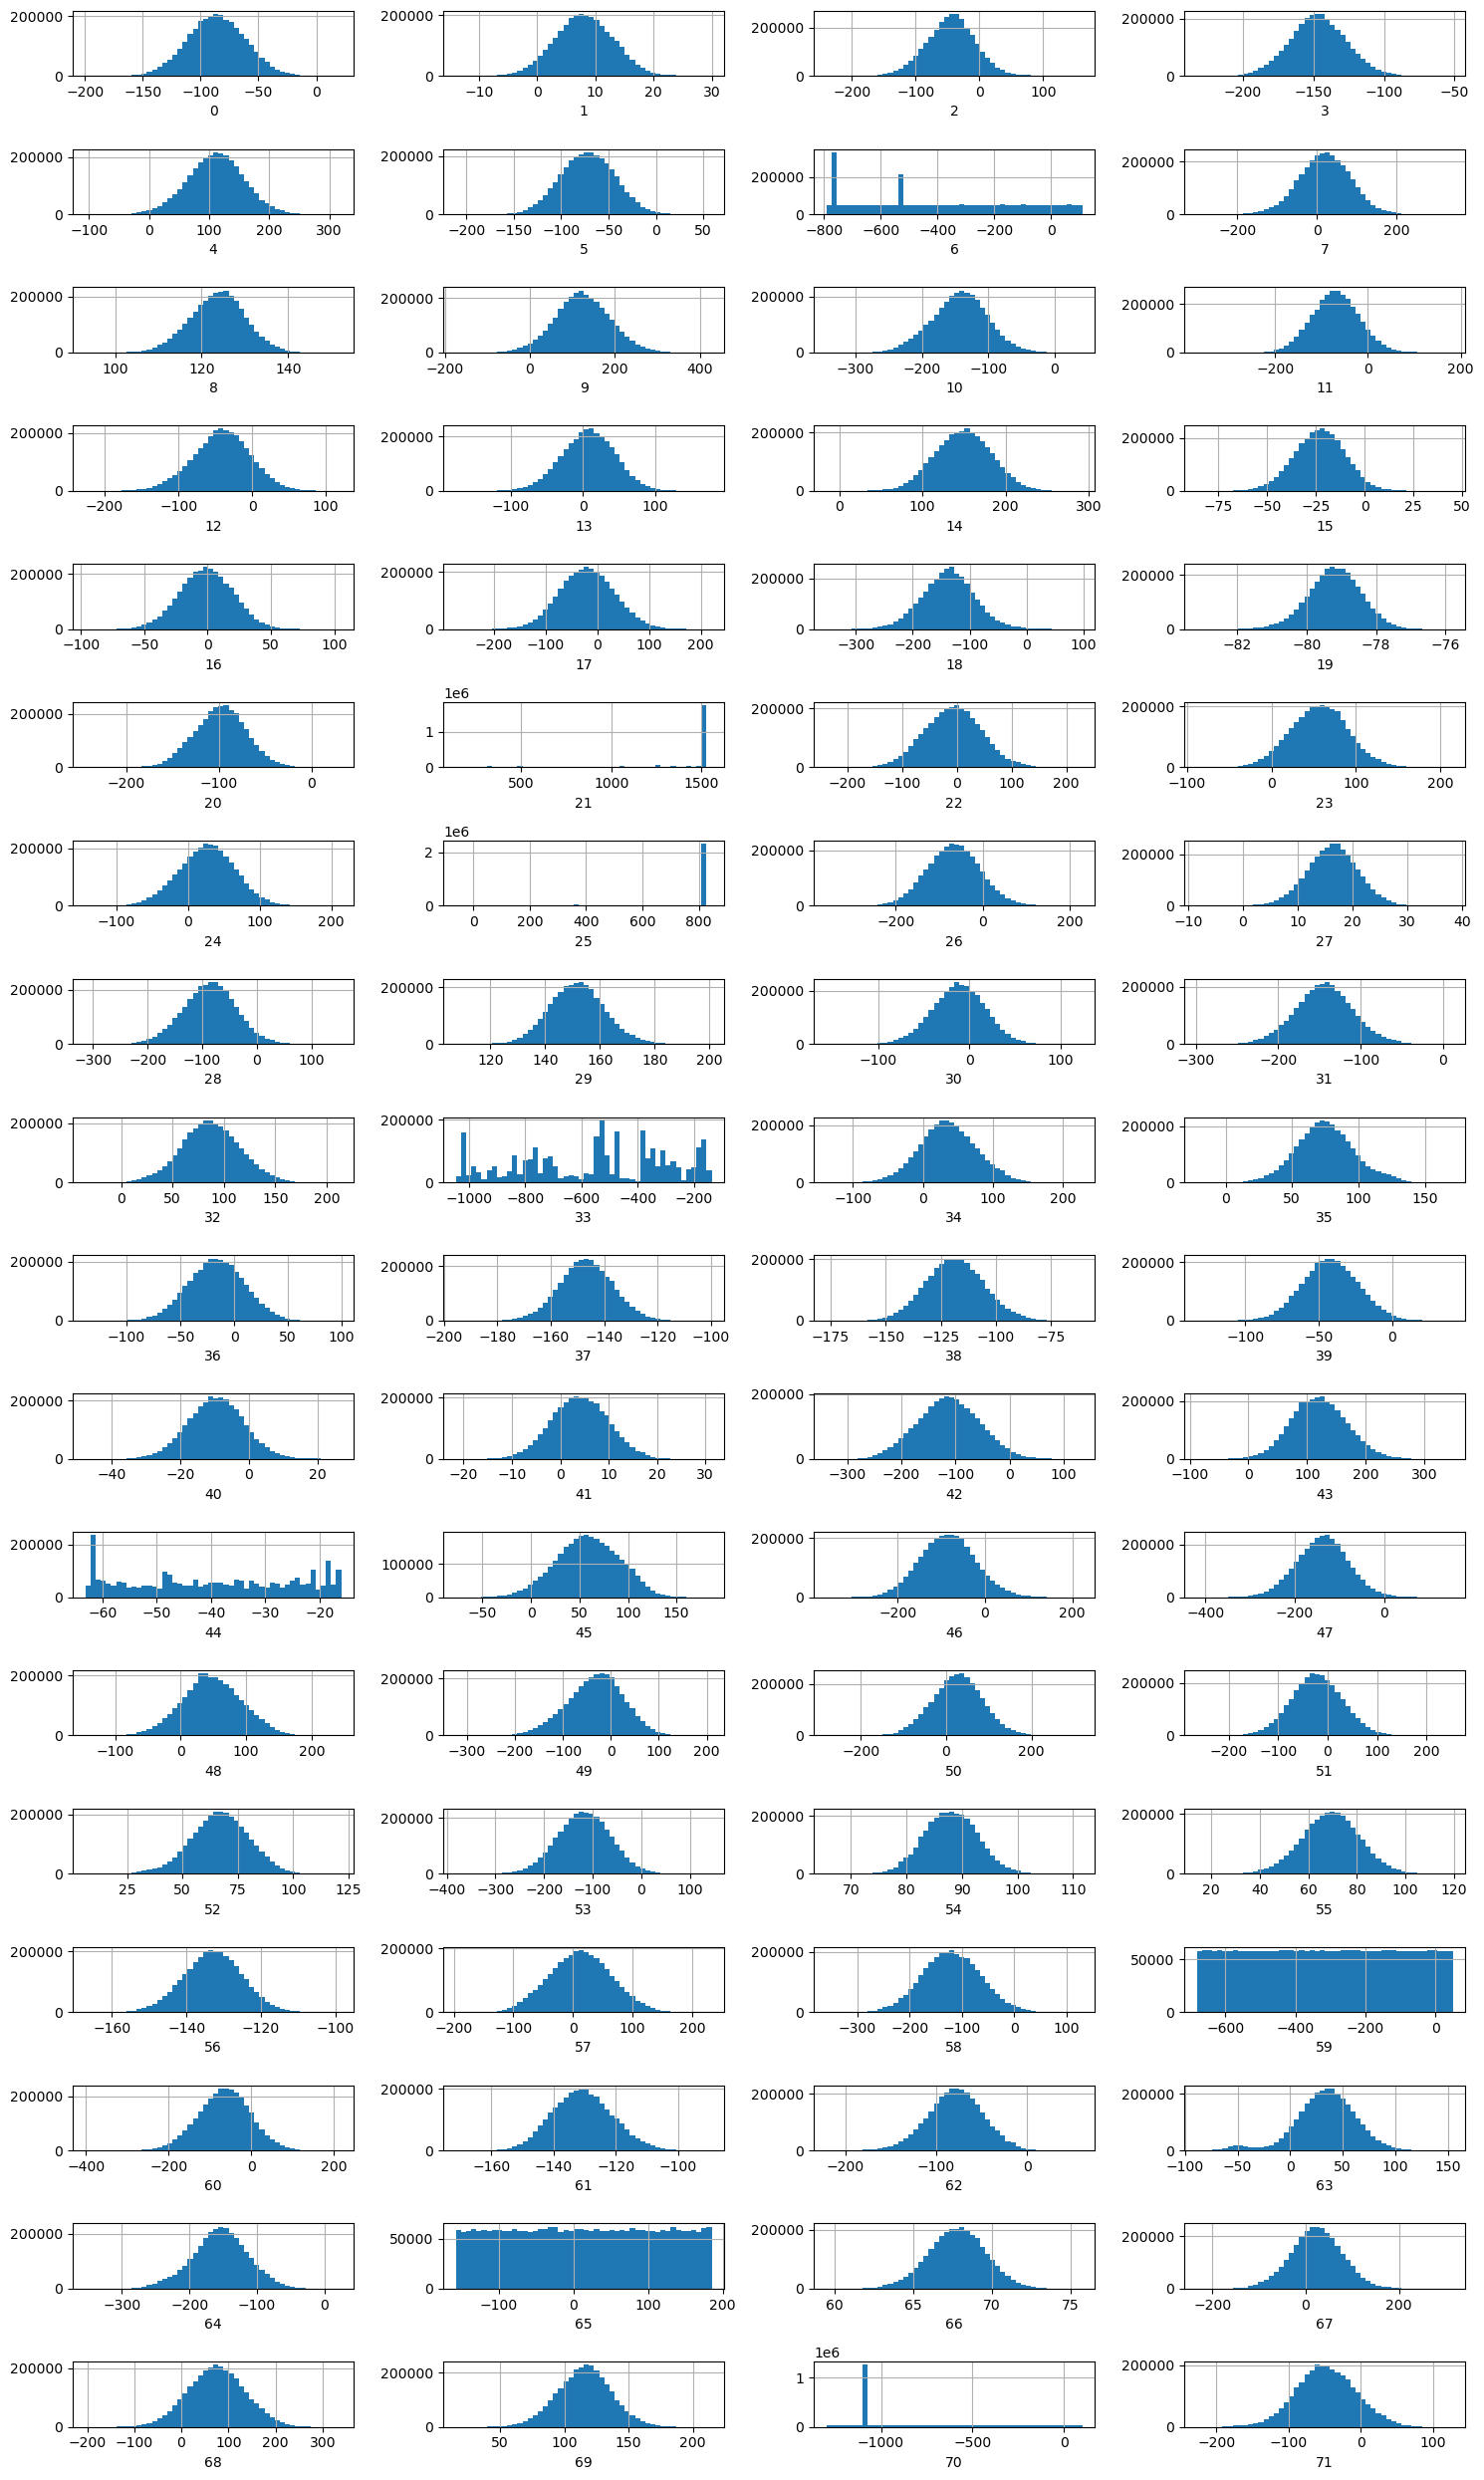

In [8]:
cols = df_train.columns

fig = plt.figure(figsize=(15,25))
for i in range(len(cols)):
    fig.add_subplot(18, 4, i+1)
    plt.hist(df_base[cols[i]], bins=50)
    #plt.ylabel('Число измерений') 
    plt.xlabel(cols[i])
    plt.tight_layout()
    plt.grid(True);    

In [9]:
suspisious_cols = ['6', '21', '25', '59', '65', '70']

### Searching candidates with FAISS

defining `candidate_search` function:

In [10]:
def candidate_search(df, df_target):
    start = time.time()
    distances, idx = idx_l2.search(np.ascontiguousarray(df.values).astype('float32'), n_neigbours)
    print('search took {}'.format(time.time() - start))
    
    acc = 0
    for target, el in zip(df_target.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])        
    print('neighbours found: {} %'.format(100 * acc / len(idx)))
    return distances, idx

Searching for `df_train`:

In [11]:
distances_train, idx_train = candidate_search(df_train, targets_train)

search took 669.9913804531097
neighbours found: 16.198 %


Searching for `df_valid`:

In [12]:
distances_valid, idx_valid = candidate_search(df_valid, targets_valid)

search took 669.8502388000488
neighbours found: 15.584 %


## Creating big `all-features` dataframes

defining `saving_big_df` function:

In [13]:
def saving_big_df(idx, distances, df, df_target, type):
    features_list = []
    target_list = []
    idx_d_list = []
    for i in tqdm(range(len(df))):
        q = [df[i] for index in idx[i]]
        p = [base[index] for index in idx[i]]
        d = [distance for distance in distances[i]]
        j = [index for index in idx[i]]
        t = np.array([1 if base_index[index] == df_target.values.tolist()[i] else 0 for index in idx[i]])
        target_list.append(t)
        features_list.append(np.concatenate((q, p), axis = 1)) 
        idx_d_list.append(np.vstack((j, d)).T)
        del q, p, t, j, d
                
    del df
    gc.collect()    
    print('lists created...')
    pd.DataFrame(np.concatenate(target_list)).to_csv(PATH + 'target_'+ type + '.csv')
    del target_list
    print('targets saved...')
    pd.DataFrame(np.concatenate(idx_d_list)).to_csv(PATH + 'faiss_idx_and_distances_'+ type + '.csv')
    del idx_d_list
    print('indexes ad distances saved...')
    pd.DataFrame(np.concatenate(features_list)).to_csv(PATH + 'all_features_'+ type + '.csv')
    del features_list
    print('features saved!')
    gc.collect()

In [14]:
base = np.array(df_base.reset_index(drop=True))
train = np.array(df_train.drop(suspisious_cols, axis=1).reset_index(drop=True))
valid = np.array(df_valid.drop(suspisious_cols, axis=1).reset_index(drop=True))

In [15]:
del df_base
del df_train
del df_valid
gc.collect()

0

### train `all-features` saving

In [16]:
saving_big_df(idx_train, distances_train, train, targets_train, 'train')

  0%|          | 0/100000 [00:00<?, ?it/s]

lists created...
targets saved...
indexes ad distances saved...
features saved!


### valid `all-features` saving

In [17]:
saving_big_df(idx_valid, distances_valid, valid, targets_valid, 'valid')

  0%|          | 0/100000 [00:00<?, ?it/s]

lists created...
targets saved...
indexes ad distances saved...
features saved!


As mentioned, there is a lack of RAM on the local machine. For the possibility of further work, the second part is located in  `stock_matching_catboost_ranking.ipynb`

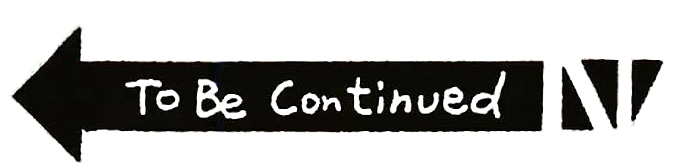